The goal of this notebook is to experiment with designing different neural networks for encoding and decoding images using the PyTorch library.  For this purpose, we'll use the classic MNIST dataset of handwritten numbers.  

We'll begin by designing a simple linear neural network to assess performance.  Afterwards, we'll try a convolutional neural network, which is more appropriate for image-based analyses.

In [1]:
#Import needed packages
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
#Load MNIST data
transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64, shuffle=True)

In [3]:
#Find image values we're working with
dataiter = iter(data_loader)
images, labels = next(dataiter)
print('Minimum pixel values in images:  ' + str(torch.min(images)))
print('Maximum pixel values in images:  ' + str(torch.max(images)))

Minimum pixel values in images:  tensor(0.)
Maximum pixel values in images:  tensor(1.)


In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        #Encoder function
        #Initial batch size N, images have size 28x28 (784 pixels)
        super().__init__() #Initialize superclass
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128), #Reduce size from N - 784 to N - 128
            nn.ReLU(), #Activation function
            nn.Linear(128, 64), #Reduce size from N - 128 to N - 64
            nn.ReLU(),
            nn.Linear(64, 12), #Reduce size from N - 64 to N - 12
            nn.ReLU(),
            nn.Linear(12, 3) #Reduce size from N - 12 to N - 3
        )

        #Decoder function
        #Reverse the encoder function, start with size 3, end with 28x28 (and batch size N)
        self.decoder = nn.Sequential(
            nn.Linear(3,12), #Increase size from N - 3 to N - 12
            nn.ReLU(),
            nn.Linear(12,64), #Increase size from N - 12 to N - 64
            nn.ReLU(),
            nn.Linear(64,128), #Increase size from N - 64 to N - 128
            nn.ReLU(),
            nn.Linear(128, 28*28), #Increase size from N - 128 to N - 28x28
            nn.Sigmoid() #Activation function with values between 0 and 1
        )
    
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [5]:
#Model parameters
model = Autoencoder()
criterion = nn.MSELoss() #Mean Squared Error loss
#Adam optimizer, learning rate of 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [6]:
#Model training
num_epochs = 10
outputs = [] #List for storing outputs
for epoch in range(num_epochs): #Iterate over epochs
    for (img, _) in data_loader: #Iterate over dataloader
        img = img.reshape(-1, 28*28) #Need images (shape 28x28) in shape 784
        recon = model(img) #Call model and get reconstructed image
        loss = criterion(recon, img) #Compare reconstructed image and original image, calculate MSE

        optimizer.zero_grad() #Zero gradients
        loss.backward() #Propogate loss backward
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}') #Print loss after each image
    outputs.append((epoch, img, recon)) #Store epoch, image, and reconstructed image

Epoch:1, Loss:0.0545
Epoch:2, Loss:0.0485
Epoch:3, Loss:0.0452
Epoch:4, Loss:0.0395
Epoch:5, Loss:0.0366
Epoch:6, Loss:0.0372
Epoch:7, Loss:0.0378
Epoch:8, Loss:0.0331
Epoch:9, Loss:0.0377
Epoch:10, Loss:0.0326


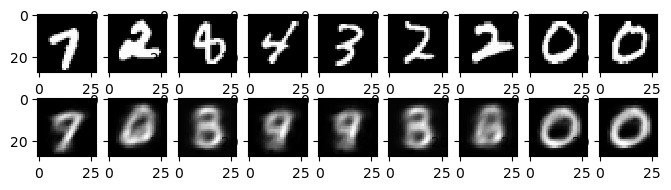

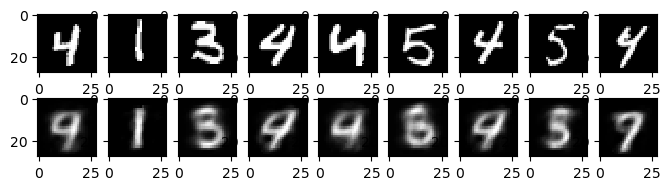

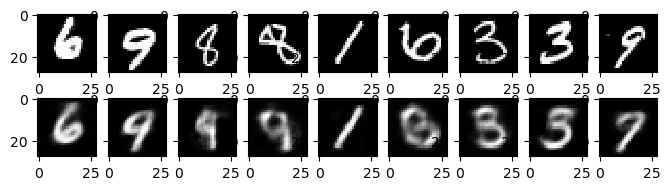

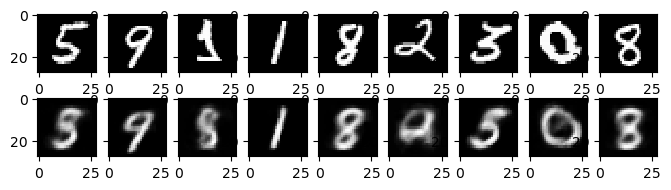

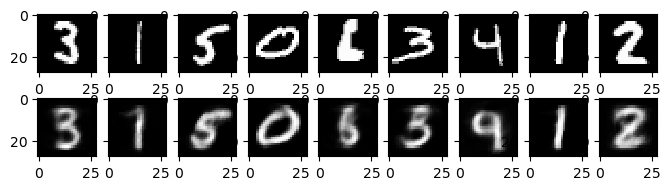

In [7]:
#Print outputs
for k in range(0, num_epochs, 2): #Print every other epoch
    plt.figure(figsize=(8,2))
    plt.gray() #Grayscale images
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break #Plot first 9 images
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) #Reshape from 784 to 28x28 image
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break #Plot first 9 images
        plt.subplot(2, 9, 9+i+1) #row_length + i + 1
        item = item.reshape(-1, 28,28) #Reshape from 784 to 28x28 image
        plt.imshow(item[0])

In [8]:
#Now try convolutional autoencoder
class Autoencoder_Conv(nn.Module):
    def __init__(self):
        #Encoder function
        #Initial batch size N, images have input size 1x28x28 (784 pixels)
        super().__init__() #Initialize superclass
        self.encoder = nn.Sequential(
            #Input Channels = 1, Output Channels = 16, Kernel Size = 3
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  #Size of N, 16x14x14
            nn.ReLU(), #Activation function
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  #Size of N, 32x7x7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) #Size of N, 64x1x1
        )

        #Decoder function
        #Reverse the encoder function, start with size 64x1x1, end with 1x28x28 (and batch size N)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), #Size of N, 32x7x7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), #Size of N, 16x14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), #Size of N, 1x28x28
            nn.Sigmoid() #Activation function with values between 0 and 1
        )
    
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
#Model parameters for convolutional version
model = Autoencoder_Conv()
criterion = nn.MSELoss() #Mean Squared Error loss
#Adam optimizer, learning rate of 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [10]:
#Model training for convolutional version (just cuts the reshaping step)
num_epochs = 10
outputs_conv = [] #List for storing outputs
for epoch in range(num_epochs): #Iterate over epochs
    for (img, _) in data_loader: #Iterate over dataloader
        recon = model(img) #Call model and get reconstructed image
        loss = criterion(recon, img) #Compare reconstructed image and original image, calculate MSE

        optimizer.zero_grad() #Zero gradients
        loss.backward() #Propogate loss backward
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}') #Print loss after each image
    outputs_conv.append((epoch, img, recon)) #Store epoch, image, and reconstructed image

Epoch:1, Loss:0.0091
Epoch:2, Loss:0.0052
Epoch:3, Loss:0.0041
Epoch:4, Loss:0.0033
Epoch:5, Loss:0.0029
Epoch:6, Loss:0.0030
Epoch:7, Loss:0.0025
Epoch:8, Loss:0.0027
Epoch:9, Loss:0.0031
Epoch:10, Loss:0.0022


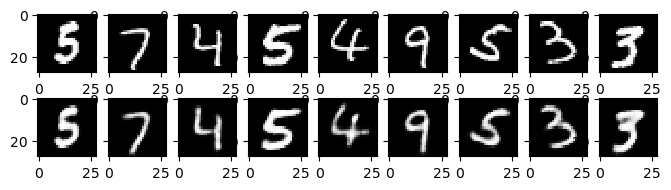

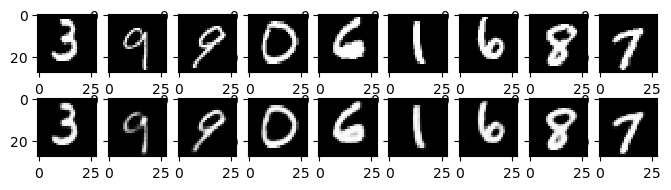

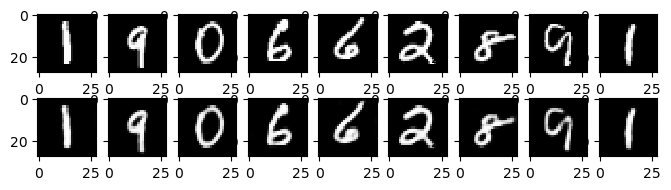

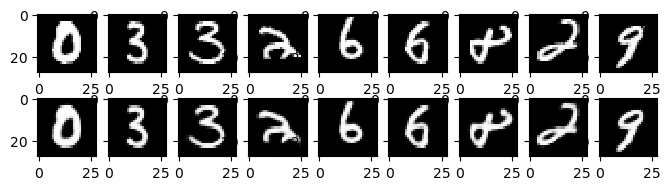

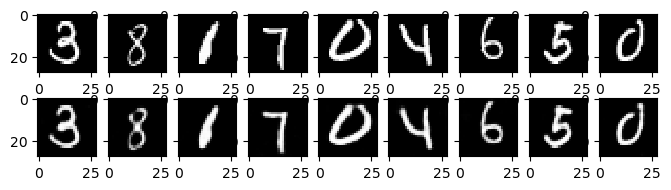

In [11]:
#Print outputs for convolutional version
for k in range(0, num_epochs, 2): #Print every other epoch
    plt.figure(figsize=(8,2))
    plt.gray() #Grayscale images
    imgs = outputs_conv[k][1].detach().numpy()
    recon = outputs_conv[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break #Plot first 9 images
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break #Plot first 9 images
        plt.subplot(2, 9, 9+i+1) #row_length + i + 1
        plt.imshow(item[0])

Overall, the simple linear autoencoder performed fairly well, but there were a number of examples where the encoded number and the decoded number were no longer the same. Additionally, the losses, though potentially improved by using more epochs, were fairly large (~0.03).

Using a convolutional neural network massively improved performance, with outputs nearly perfectly matching the inputs, and all numbers appearing to have been correctly encoded.  The improvement in performance is observerable in the model losses, which are over an order of magnitude smaller than those observed in the linear autoencoder (~0.002).